In [1]:
import os
import sys
import glob
import math
import itertools
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Add parent directory to path
sys.path.append(str(Path("..").resolve()))
from data_handling import load_state_npz

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_dir = Path("models")
state_dir = Path("state_vectors")

print(f"Running on: {device}")
print(f"Looking for models in: {models_dir.resolve()}")

Running on: cpu
Looking for models in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_over_4x4_tests/models


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        fe_v = term1_v - term2_v
        fe_flipped = term1_f - term2_f

        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / self.T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    # Standard sampling generation
    @torch.no_grad()
    def generate(self, cond: torch.Tensor, n_samples: int, rng: torch.Generator, burn_in: int = 50):
        cond = cond.to(device)
        if cond.dim() == 1: cond = cond.expand(n_samples, -1)

        b_mod, c_mod = self._compute_effective_biases(cond)

        # Random init
        probs = torch.full((n_samples, self.num_visible), 0.5, device=device)
        v = torch.bernoulli(probs, generator=rng)

        for _ in range(burn_in):
            v = self._gibbs_step(v, b_mod, c_mod, rng)
        return v

In [3]:
def load_latest_model():
    pt_files = sorted(glob.glob(str(models_dir / "*.pt")), key=os.path.getmtime, reverse=True)
    if not pt_files:
        raise FileNotFoundError("No .pt files found in models directory.")

    latest_path = pt_files[0]
    print(f"Loading checkpoint: {latest_path}")

    checkpoint = torch.load(latest_path, map_location=device)
    config = checkpoint["config"]

    model = ConditionalRBM(
        num_visible=config["num_visible"],
        num_hidden=config["num_hidden"],
        cond_dim=1,
        k=config.get("k_steps", 1),
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    return model, config

model, config = load_latest_model()
GEN_SIDE_LENGTH = int(math.sqrt(model.num_visible))
print(f"Model Loaded. System Size: {GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}")

Loading checkpoint: models/crbm_tfim_4x4_50000_20251210_223015.pt
Model Loaded. System Size: 4x4


In [4]:
@torch.no_grad()
def estimate_fidelity_mc(model, h_val, n_samples=10000):
    """
    Estimates Fidelity using Two-Way Monte Carlo.
    1. Sample from RBM -> Estimate E1 = <Psi_E / Psi_M>
    2. Sample from Exact -> Estimate E2 = <Psi_M / Psi_E>
    3. F = sqrt(E1 * E2)
    """
    # 1. Load Exact State
    state_path = state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h_val:.2f}.npz"
    if not state_path.exists():
        print(f"Warning: No exact state found for h={h_val}")
        return None

    psi_np, _ = load_state_npz(state_path)
    psi_exact_vec = torch.from_numpy(psi_np).real.float().to(device)
    # Ensure exact state is normalized
    psi_exact_vec = psi_exact_vec / torch.norm(psi_exact_vec)

    # ---------------------------------------------------------
    # PART A: Sample from RBM (Forward)
    # ---------------------------------------------------------
    rng = torch.Generator(device=device).manual_seed(42)
    cond = torch.tensor([[h_val]], device=device)

    # Generate bitstrings
    samples_rbm = model.generate(cond, n_samples, rng, burn_in=100)

    # Calculate RBM Log Amplitudes for these samples
    cond_batch = cond.expand(n_samples, -1)
    log_psi_rbm = model.log_score(samples_rbm, cond_batch)

    # Lookup Exact Amplitudes for these samples
    # Convert bitstrings to indices [0...2^N-1]
    powers = 2 ** torch.arange(GEN_SIDE_LENGTH**2 - 1, -1, -1, device=device)
    indices_rbm = (samples_rbm * powers).sum(dim=1).long()

    psi_exact_vals = psi_exact_vec[indices_rbm]

    # Ratio: Psi_E / Psi_M = exp(ln Psi_E - ln Psi_M)
    # Note: Use abs for stability, assuming sign structure is matched or J=-1
    ratio_1 = torch.abs(psi_exact_vals) / torch.exp(log_psi_rbm)
    E1 = ratio_1.mean()

    # ---------------------------------------------------------
    # PART B: Sample from Exact (Reverse)
    # ---------------------------------------------------------
    # Create probability distribution |Psi_E|^2
    probs_exact = psi_exact_vec**2

    # Sample indices from Exact Distribution
    indices_exact = torch.multinomial(probs_exact, n_samples, replacement=True)

    # Convert indices back to bitstrings for the RBM
    # (Inverse of the powers operation)
    # Shape: (N_samples, N_qubits)
    samples_exact = ((indices_exact.unsqueeze(1) & powers.unsqueeze(0)) > 0).float()

    # RBM Log Amplitudes
    log_psi_rbm_rev = model.log_score(samples_exact, cond_batch)

    # Exact Amplitudes
    psi_exact_vals_rev = psi_exact_vec[indices_exact]

    # Ratio: Psi_M / Psi_E
    ratio_2 = torch.exp(log_psi_rbm_rev) / torch.abs(psi_exact_vals_rev)
    E2 = ratio_2.mean()

    # ---------------------------------------------------------
    # COMBINE
    # ---------------------------------------------------------
    # F^2 = E1 * E2
    f_squared = E1 * E2
    fidelity = torch.sqrt(f_squared)

    return fidelity.item()

Evaluating on 7 points: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
h=1.00 [SUPPORT] | Fidelity (MC) = 0.99976
h=2.00 [SUPPORT] | Fidelity (MC) = 0.99882
h=3.00 [SUPPORT] | Fidelity (MC) = 0.99750
h=4.00 [SUPPORT] | Fidelity (MC) = 0.99891
h=5.00 [SUPPORT] | Fidelity (MC) = 0.99908
h=6.00 [SUPPORT] | Fidelity (MC) = 0.99938
h=7.00 [SUPPORT] | Fidelity (MC) = 0.99941


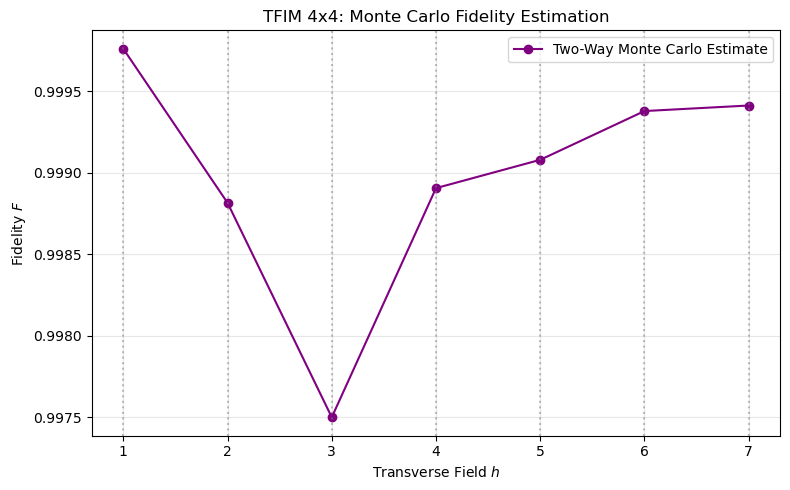

In [5]:
# Setup Sweep
h_eval_min = 1.0
h_eval_max = 7.0
n_points = 20
h_values = sorted(list(set(
    np.linspace(h_eval_min, h_eval_max, n_points).tolist() +
    config["h_support"] # Ensure we hit training points
)))
h_values = [round(h, 2) for h in h_values]

# Filter to available ground truth files
available_h = []
for h in h_values:
    if (state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h:.2f}.npz").exists():
        available_h.append(h)

print(f"Evaluating on {len(available_h)} points: {available_h}")

mc_fidelities = []

for h in available_h:
    fid = estimate_fidelity_mc(model, h, n_samples=20000)
    mc_fidelities.append(fid)

    # Helper print
    is_supp = h in config["h_support"]
    tag = "[SUPPORT]" if is_supp else "         "
    print(f"h={h:.2f} {tag} | Fidelity (MC) = {fid:.5f}")

# Plotting
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(available_h, mc_fidelities, 'o-', color='purple', label="Two-Way Monte Carlo Estimate")

# Mark support points
ymin, ymax = plt.ylim()
for h_s in config["h_support"]:
    if h_s in available_h:
        plt.axvline(h_s, color='gray', linestyle=':', alpha=0.5)

plt.xlabel(r"Transverse Field $h$")
plt.ylabel(r"Fidelity $F$")
plt.title(f"TFIM 4x4: Monte Carlo Fidelity Estimation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()